In [2]:
import neurokit2 as nk
import os
import wfdb
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pywt
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
file_path = Path('C:/Users/vinay/Downloads/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0')
file_name = '233'
file = os.path.join(file_path, file_name)

In [4]:
signal, field = wfdb.rdsamp(file)
annotation = wfdb.rdann(file, 'atr')

In [5]:
fs = 360
lowcut = 0.5
highcut = 45
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')
filtered_signal = filtfilt(b, a, signal[:, 0])

In [6]:
coeffs = pywt.wavedec(filtered_signal, 'db6', level=9)
coeffs[0] = np.zeros_like(coeffs[0])  # Remove cA9 (Baseline Wander)
coeffs[1] = np.zeros_like(coeffs[1])  # Remove cD9 (Low-frequency drift)
coeffs[9] = np.zeros_like(coeffs[9])  # Remove cD1 (High-frequency noise)
coeffs[8] = np.zeros_like(coeffs[8])  # Remove cD2 (High-frequency noise)
coeffs[7] = np.zeros_like(coeffs[7])


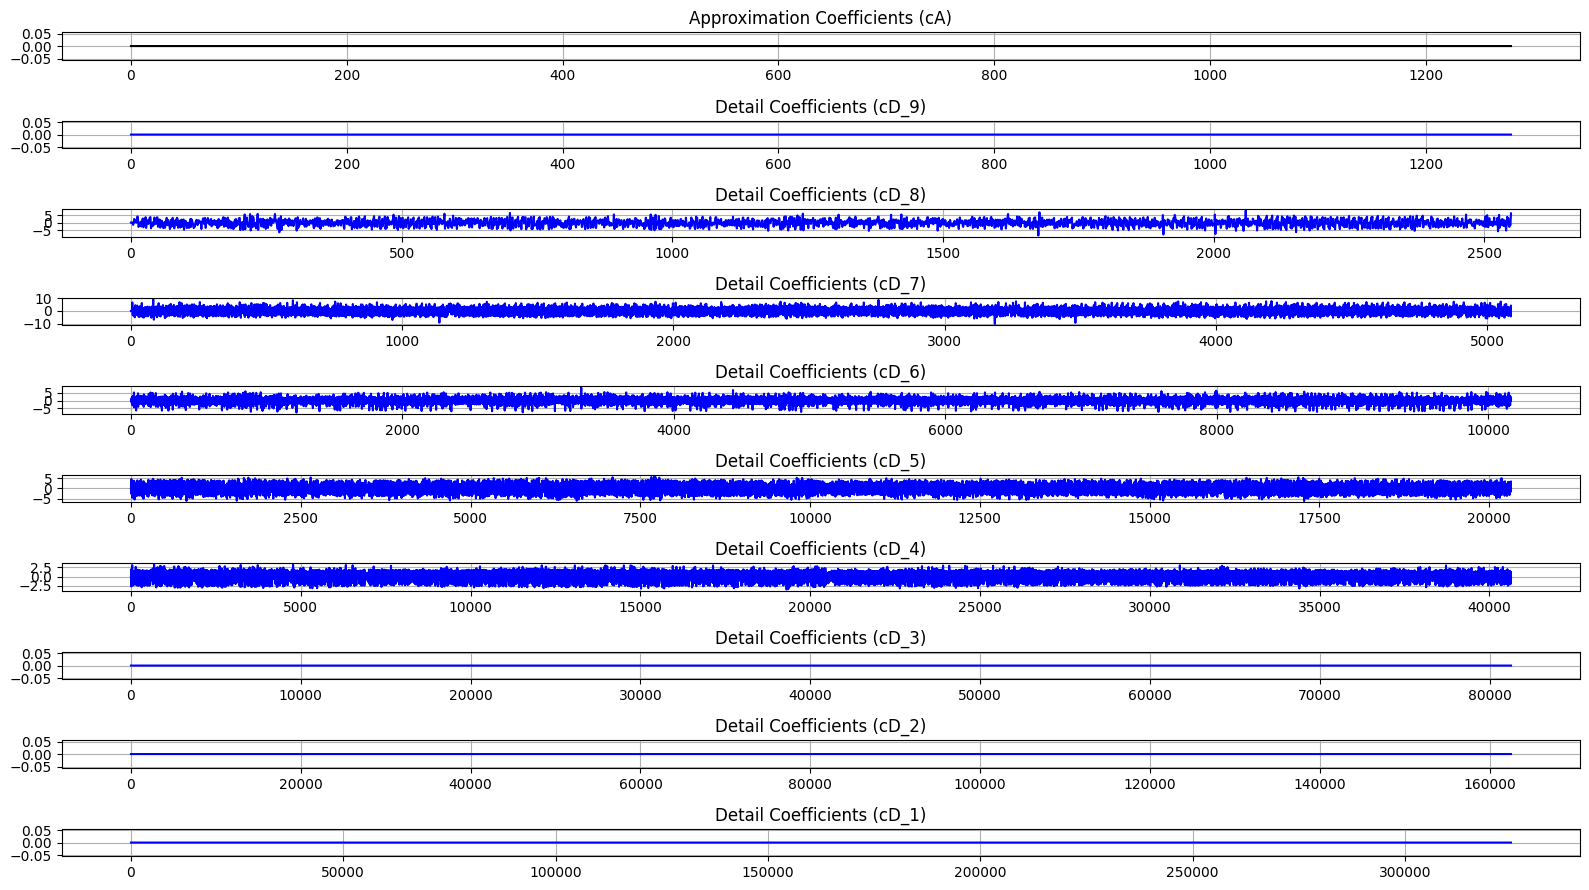

In [7]:
level=9
plt.figure(figsize=(16, 9))

# Approximation coefficients (cA)
plt.subplot(level + 1, 1, 1)
plt.plot(coeffs[0], color='black')
plt.title("Approximation Coefficients (cA)")
plt.grid()

# Detail coefficients (cD)
for i in range(1, level + 1):
    plt.subplot(level + 1, 1, i + 1)
    plt.plot(coeffs[i], color='blue')
    plt.title(f"Detail Coefficients (cD_{level-i+1})")
    plt.grid()

plt.tight_layout()
plt.show()

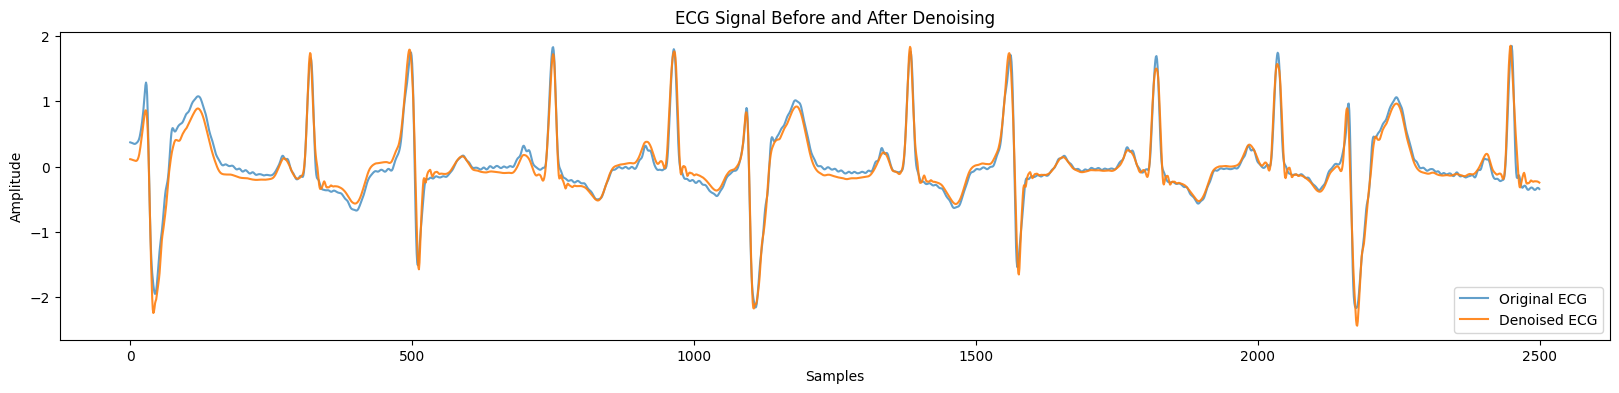

In [8]:
denoised_signal = pywt.waverec(coeffs, 'db6')

# Plot original and denoised signals
plt.figure(figsize=(20, 4))
plt.plot(filtered_signal[:2500], label="Original ECG", alpha=0.7)
plt.plot(denoised_signal[:2500], label="Denoised ECG", alpha=0.9) 
plt.legend()
plt.title("ECG Signal Before and After Denoising")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

In [9]:
signals, info = nk.ecg_process(denoised_signal[:])

C:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neurokit2\ecg\ecg_plot.py:70: NeuroKitWarning: 'info' dict not provided. Some information might be missing. Sampling rate will be set to 1000 Hz.
  warn(


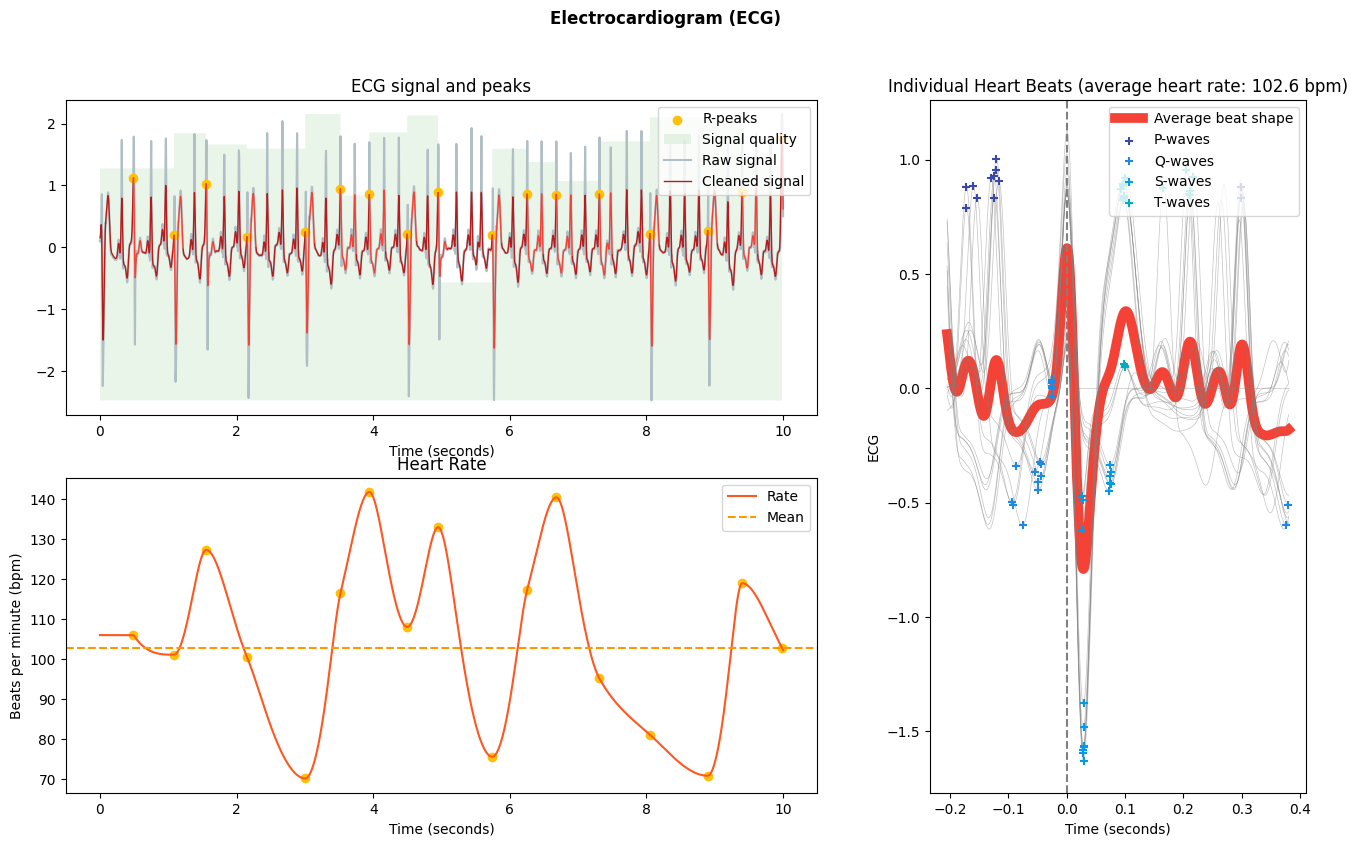

In [10]:
nk.ecg_plot(signals[:10000])
plt.gcf().set_size_inches(16, 9)  # Width: 12 inches, Height: 6 inches
plt.show()

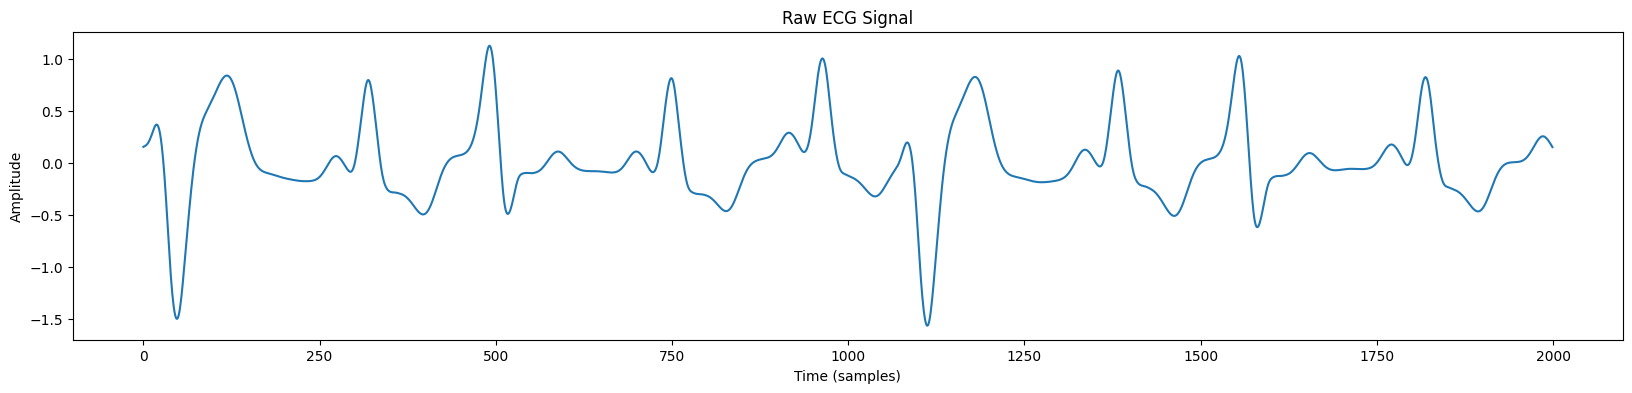

In [11]:
plt.figure(figsize=(20, 4))
plt.plot(signals.ECG_Clean[:2000]) 
plt.title('Raw ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

In [12]:
segmented_signals = [denoised_signal[max(0, peak-64):min(len(denoised_signal), peak+64)] for peak in annotation.sample]

In [13]:
def build_cnn_lstm_model(num_classes):
    input_layer = tf.keras.layers.Input(shape=(128, 1))
    
    # CNN Layers
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # LSTM Layers
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(32, return_sequences=False)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Fully connected layer
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # Classification head
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # Use 'sigmoid' for binary classification

    # Define the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [14]:
# Define the number of classes
num_classes = 6  # Example: 5 classes for arrhythmia types

# Build the model
model = build_cnn_lstm_model(num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             

 Total params: 397,126 (1.51 MB)

 Trainable params: 396,166 (1.51 MB)

 Non-trainable params: 960 (3.75 KB)

In [15]:
segmented_array=np.empty((0, 128))
for signal in segmented_signals:    
    if len(signal) < 128:
        signal = np.pad(signal, (0, 128 - len(signal)), mode='edge')
    segmented_array=np.vstack((segmented_array, signal))
segmented_array.shape

(3152, 128)

In [16]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(segmented_array)  # Normalize the feature matrix

# Step 2: Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_scaled, annotation.symbol, test_size=0.25, random_state=42)
X_train = X_train.reshape(-1, 128, 1)
X_test = X_test.reshape(-1, 128, 1)

In [17]:
char_to_int = {'N': 0, 'V': 1, 'A': 2, 'F': 3, '+': 4, '|': 5}

# Convert y_train and y_val to integer labels
y_train_int = [char_to_int[char] for char in y_train]
y_val_int = [char_to_int[char] for char in y_test]

In [18]:
# Number of classes
num_classes = len(char_to_int)  # In this case, 6 classes

# One-hot encode y_train and y_val
y_train = to_categorical(y_train_int, num_classes=num_classes)
y_test = to_categorical(y_val_int, num_classes=num_classes)

In [19]:
history = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))

Epoch 1/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7883 - loss: 0.8948 - val_accuracy: 0.7195 - val_loss: 1.5748
Epoch 2/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9584 - loss: 0.1901 - val_accuracy: 0.7246 - val_loss: 1.7709
Epoch 3/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9695 - loss: 0.1315 - val_accuracy: 0.7525 - val_loss: 1.2719
Epoch 4/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9707 - loss: 0.1255 - val_accuracy: 0.7335 - val_loss: 1.4772
Epoch 5/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9619 - loss: 0.1357 - val_accuracy: 0.7703 - val_loss: 1.2377
Epoch 6/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9754 - loss: 0.0939 - val_accuracy: 0.7513 - val_loss: 0.8169
Epoch 7/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9819 - loss: 0.0893 - val_accuracy: 0.8274 - val_loss: 0.4582
Epoch 8/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9879 - loss: 0.0591 - val_accuracy: 0.9607 - v

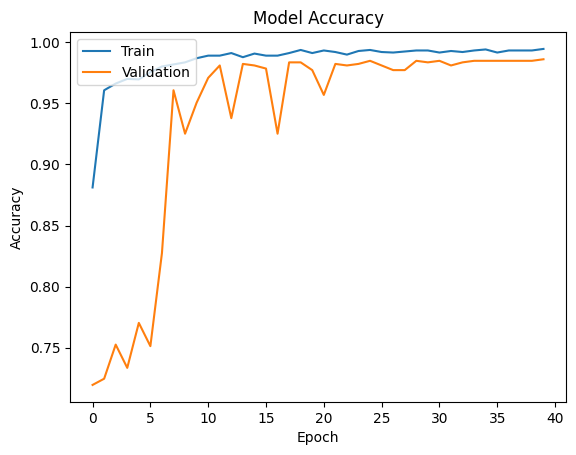

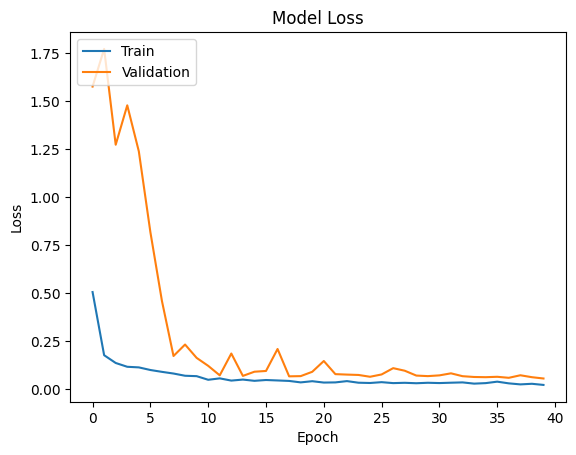

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


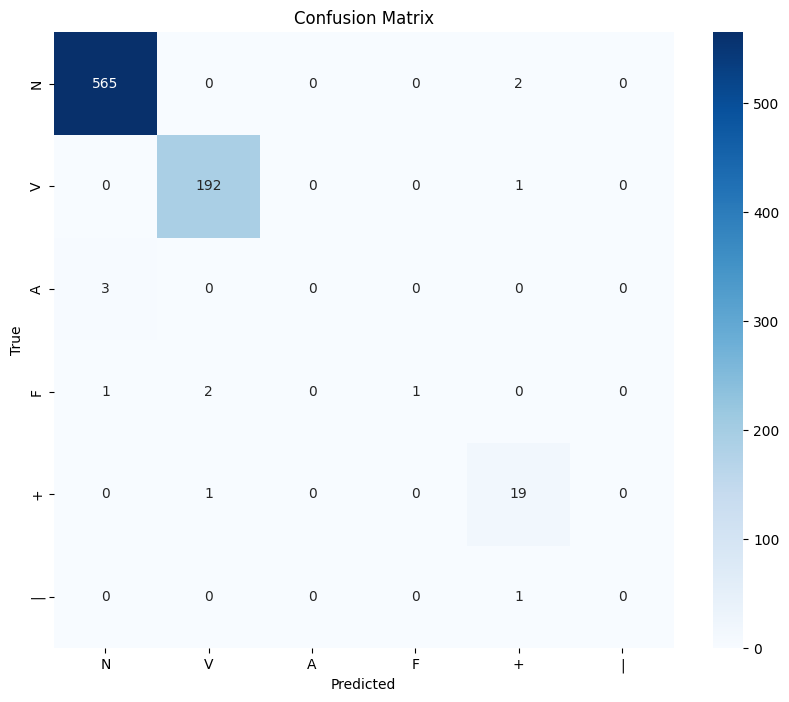

In [21]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=char_to_int.keys(), 
            yticklabels=char_to_int.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


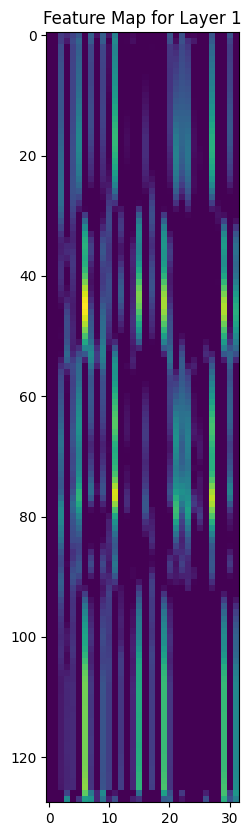

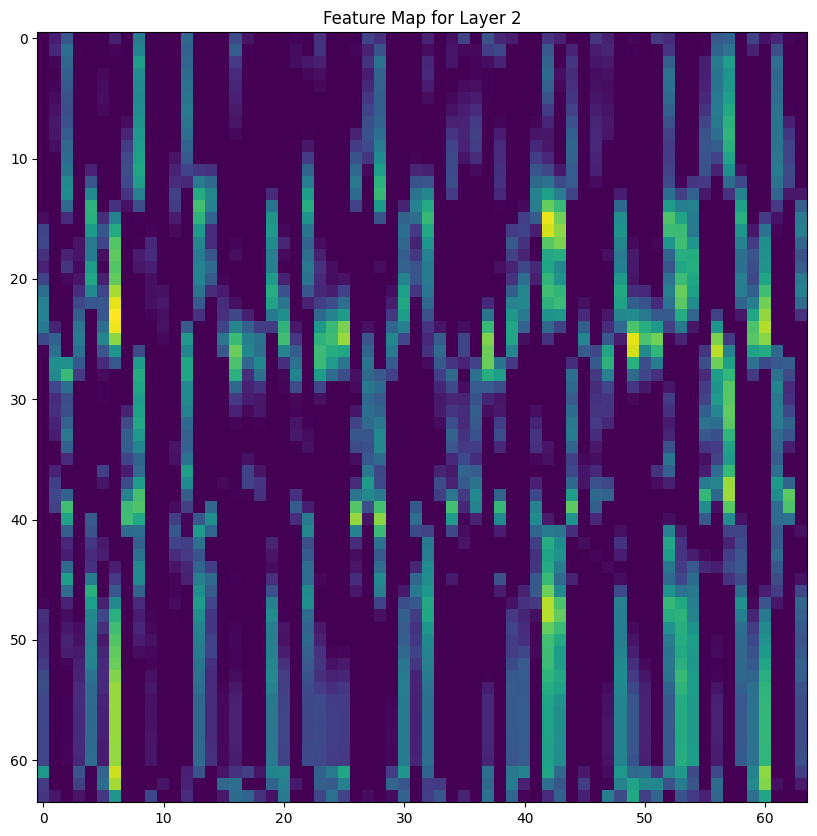

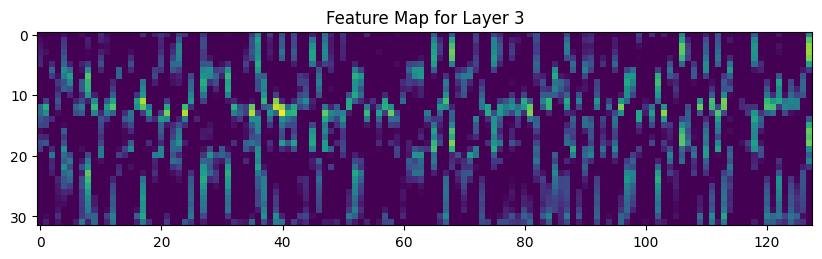

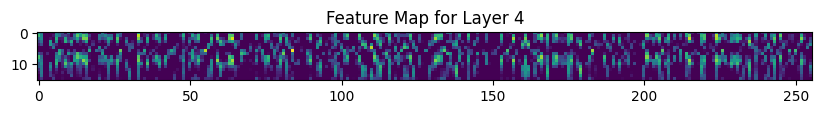

In [22]:
from tensorflow.keras.models import Model

# Create a model to visualize feature maps
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]  # Get CNN layer outputs
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get feature maps for a sample input
sample_input = X_test[100:101]  # Take one sample
activations = activation_model.predict(sample_input)

# Plot feature maps
for i, activation in enumerate(activations):
    plt.figure(figsize=(10, 10))
    plt.title(f'Feature Map for Layer {i+1}')
    plt.imshow(activation[0, :, :], cmap='viridis')  # Plot the first filter
    plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


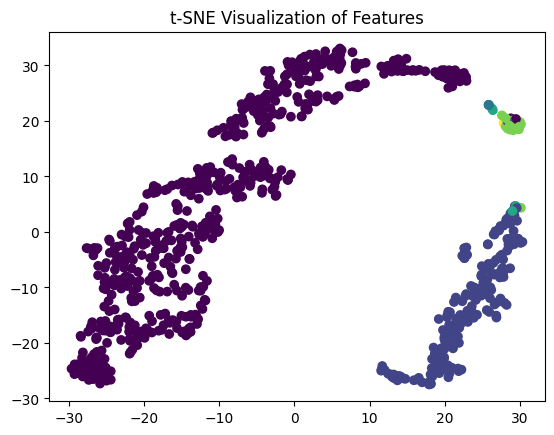

In [23]:
from sklearn.manifold import TSNE

# Extract features from the last layer before the output
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
features = feature_extractor.predict(X_test)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot t-SNE
plt.figure()
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_true_classes, cmap='viridis')
plt.title('t-SNE Visualization of Features')
plt.show()

In [24]:
model.save('CNN-LSTM.h5')